In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ausair = pd.read_csv('data/passengers.csv')
ausair = ausair['num_passengers']

In [4]:
def box_koks(vals: np.array, lambd: float) -> np.array:
    plus = 0
    if min(vals) < 0:
        plus = -min(vals)
    if lambd == 0:
        new_vals = np.log(vals + plus)
    else:
        new_vals = (vals**lambd - 1)/lambd
    return new_vals

In [5]:
def max_pravd(vals: np.array, lambd: float) -> float:
    new_vals = box_koks(vals, lambd)
    T = len(vals)
    plus = 0
    if min(vals) < 0:
        plus = -min(vals)
    max_pravd_sum = T/2 * np.log(sum((new_vals - new_vals.mean())**2)/T) - (lambd - 1) * sum(np.log(vals + plus))
    return max_pravd_sum

In [6]:
mp = lambda x: max_pravd(ausair.values, x[0])
df = minimize(mp, (0))
df.x[0]

0.14802225912984354

In [7]:
data = pd.DataFrame(ausair)
data['box_koks'] = box_koks(ausair, df.x[0])
data['seasonal_differentiation'] = data['box_koks'].diff(periods=12)
data['ordinary_differentiation'] = data['seasonal_differentiation'].diff(periods=1)
data.head(14)

,num_passengers,box_koks,seasonal_differentiation,ordinary_differentiation
0,112,6.827483,NaN,NaN
1,118,6.932815,NaN,NaN
2,132,7.161884,NaN,NaN
3,129,7.114603,NaN,NaN
4,121,6.983780,NaN,NaN
5,135,7.208258,NaN,NaN
6,148,7.399590,NaN,NaN
7,148,7.399590,NaN,NaN
8,136,7.223521,NaN,NaN
9,119,6.949925,NaN,NaN


In [8]:
def approximation(data: np.array, params: np.array, seasonal: int, number_seasonal_parameters: int, number_autoregressive_parameters: int) -> int:
    val = pd.DataFrame({'num' : data})
    for i in range(number_autoregressive_parameters):
        val['y' + str(i + 1)] = val['num'].shift(i + 1)
    
    for i in range(1, number_seasonal_parameters + 1):
        val['y' + str(seasonal * i)] = val['num'].shift(seasonal * i)
    phi_autoregressive = params[1: number_autoregressive_parameters + 1]
    phi_autoregressive.shape = (1, len(phi_autoregressive))
    phi_seasonal = params[number_autoregressive_parameters + 1:]
    val = val.dropna()
    
    return (params[0] + phi_autoregressive @ val.iloc[:, 1: number_autoregressive_parameters + 1].T + phi_seasonal @ val.iloc[:,number_autoregressive_parameters + 1:].T).values[0]

In [9]:
def mean_square_error_for_autoregressive(data: np.array, params: np.array, number_seasonal_parameters: int, seasonal: int, number_autoregressive_parameters: int) -> int:
    lost_values = max(number_seasonal_parameters * seasonal, number_autoregressive_parameters)
    return ( (data[lost_values:] - approximation(data, params, seasonal, number_seasonal_parameters, number_autoregressive_parameters))**2 ).mean()

In [10]:
def autoregressive_se_parameter(data: np.array, number_seasonal_parameters: int, seasonal: int, number_autoregressive_parameters: int) -> np.array:
    mse = lambda x: mean_square_error_for_autoregressive(data, x, number_seasonal_parameters, seasonal, number_autoregressive_parameters)
    df = minimize(mse, np.zeros(number_seasonal_parameters + number_autoregressive_parameters + 1))
    
    return df.x

In [11]:
params = np.array([1,2,3,4,5])
len(approximation(data['ordinary_differentiation'].dropna().values, params, 12, 1, 3))

119

In [12]:
mean_square_error_for_autoregressive(data['ordinary_differentiation'].dropna().values, params, 1, 12, 3)

1.6137931560005758

In [13]:
autoregressive_se_params = autoregressive_se_parameter(data['ordinary_differentiation'].dropna().values, 1, 12, 3)

In [14]:
def error_approximation(data: np.array, params_moving_average: np.array, autoregressive_se_params: np.array, number_seasonal_parameters: int, seasonal: int, number_autoregressive_parameters:int) -> int:
    forecast = approximation(data, autoregressive_se_params,seasonal, number_seasonal_parameters, number_autoregressive_parameters)
    lost_values = max(number_seasonal_parameters * seasonal, number_autoregressive_parameters)
    
    mistake = forecast - data[lost_values:]
    
    mistake = pd.DataFrame({'num': mistake})
    
    for i in range(len(params_moving_average) - 1):
        mistake['e' + str(i + 1)] = mistake['num'].shift(i + 1)
    mistake = mistake.dropna()
    
    theta = params_moving_average[1:]
    theta.shape = (1, len(theta))
    
    return (theta @ mistake.iloc[:, 1:].T + params_moving_average[0]).values[0]

In [15]:
def mean_square_error_for_moving_average(data: np.array, mistake: np.array, params: np.array, autoregressive_se_params: np.array, number_seasonal_parameters: int, seasonal: int, number_autoregressive_parameters: int) -> int:
    return ( (mistake[len(params) - 1:] - error_approximation(data, params, autoregressive_se_params, number_seasonal_parameters, seasonal, number_autoregressive_parameters))**2 ).mean()

In [16]:
def moving_average_parameter(data: np.array, mistake: np.array, number_moving_average: int, autoregressive_se_params: np.array, number_seasonal_parameters: int, seasonal: int, number_autoregressive_parameters: int) -> np.array:    
    mse = lambda x: mean_square_error_for_moving_average(data, mistake, x, autoregressive_se_params, number_seasonal_parameters, seasonal, number_autoregressive_parameters)
    
    df = minimize(mse, np.zeros(number_moving_average + 1))
    
    return df.x

In [17]:
len(error_approximation(data['ordinary_differentiation'].dropna().values, np.array([1,2,3]), autoregressive_se_params, 1, 12, 3))

117

In [18]:
forecast = approximation(data['ordinary_differentiation'].dropna().values, autoregressive_se_params, 12, 1, 3)
lost_values = max(1 * 12, 3)

mistake = forecast - data['ordinary_differentiation'].dropna().values[lost_values:]

In [19]:
len(forecast[2:])

117

In [20]:
mean_square_error_for_moving_average(data['ordinary_differentiation'].dropna().values, mistake, np.array([1,2,3]), autoregressive_se_params, 1, 12, 3)

1.0911438736070733

In [21]:
moving_average_parameter(data['ordinary_differentiation'].dropna().values, mistake, 2, autoregressive_se_params, 1, 12, 3)

array([ 0.00070764, -0.06498901, -0.0115874 ])

In [22]:
def sarma(data: np.array, number_autoregressive_parameters: int, number_moving_average: int, number_seasonal_parameters: int, seasonal: int ,h: int) -> np.array:
    
    autoregressive_se_params = autoregressive_se_parameter(data, number_seasonal_parameters, seasonal, number_autoregressive_parameters)
    
    forecast = approximation(data, autoregressive_se_params, seasonal, number_seasonal_parameters, number_autoregressive_parameters)
    
    lost_values = max(number_seasonal_parameters * seasonal, number_autoregressive_parameters)
    
    mistake = forecast - data[lost_values:]
    
    moving_average_params = moving_average_parameter(data, mistake, number_moving_average, autoregressive_se_params, number_seasonal_parameters, seasonal, number_autoregressive_parameters)
    
    e = error_approximation(data, moving_average_params, autoregressive_se_params, number_seasonal_parameters, seasonal, number_autoregressive_parameters)

    return forecast[2:] + e

    
#     end = min(len(data) - number_autoregressive_params, len(mistake) - number_moving_average)
#     f=[]
#     for i in range(0, end + h):
#         if i < end:
#             pred = autoregressive_params[0] + (autoregressive_params[1:] @ data[i: i + number_autoregressive_params]) + moving_average_params[0] + (moving_average_params[1:] @ mistake[i: i + number_moving_average])
    
#         f.append(pred)
    
#     return np.array(f)

In [23]:
forecast22 = sarma(data['ordinary_differentiation'].dropna().values, 3, 2, 1, 12, 0)

In [24]:
reverse_ordinary_diff = data['seasonal_differentiation'].dropna().values[15:] + forecast22
reverse_season_diff = reverse_ordinary_diff + data['box_koks'].dropna().values[27:]

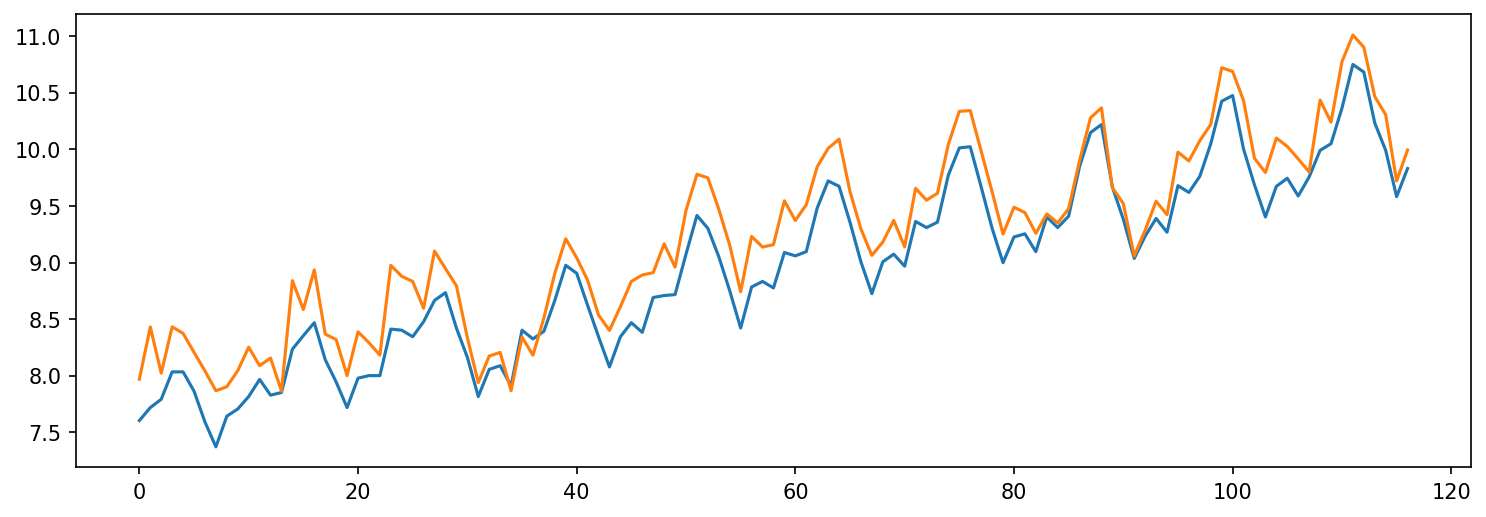

In [25]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(data['box_koks'].dropna().values[27:])
plt.plot(reverse_season_diff)
plt.show()